# Train a DNN to predict absolute free energies of binding (i.e. null model)

## Imports

In [1]:
# General:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter
import os
import csv
import time
import shutil
import logging
import pickle
import statistics
from tqdm import tqdm_notebook as tqdm

# SVM:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# SciKit-Optimise:
from skopt import gp_minimize, dump
from skopt.space import Categorical, Integer, Real
from skopt.utils import use_named_args

/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Global variables

### Model parameters

In [2]:
# Global variables:
model_type = 'DNN_null'

label_col = 'Experimental dGhydr (kcal/mol)'

# Set data processing configurations:
n_calls = 50  # Number of Bayesian optimisation loops for hyper-parameter optimisation, 40 is best for convergence, > 60 scales to very expensive
best_mae = np.inf  # Point to consider top-performing model from (MAE/MAD); 1.0 = no improvement on test-set variance

# KFold parameters:
n_splits = 5  # Number of K-fold splits
random_state = 2  # Random number seed

# RDKit:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import SDMolSupplier
from rdkit import DataStructs

### Matplotlib parameters

In [3]:
figsize = [7, 7]
fontsize = 18
markersize = 20
linewidth = 2
dGhydr_xylim = [-25.0, 5.0]
dGoffset_xylim = [-4.0, 2.0]
dpi = 300

## Path variables

In [4]:
# Path variables:
datasets_dr = '../datasets/DATASETS/'
SDF_dr = '../datasets/backend/freesolv/'
freesolv_loc = '../datasets/backend/freesolv_database.txt'  
output_dr = 'output/'
figures_dr = 'figures/'

## Data preparation

### Load data

In [5]:
feature_sets = ["APFP", "ECFP6", "TOPOL", "MolProps", "MolPropsAPFP", "MolPropsECFP6", "MolPropsTOPOL", "X-NOISE"]
training_sets = []

for feature_set in feature_sets:
    # make output directory:
    if not os.path.exists("output/"+feature_set):
        os.mkdir("output/"+feature_set)
    
    # load in this feature set:
    train_path = datasets_dr + 'null_train_'+feature_set+'.csv'
    train_df = pd.read_csv(train_path, index_col='ID').iloc[:,:-1]
    
    # assign a name attribute to recover feature type (called by df.name)
    train_df.name = feature_set
    training_sets.append(train_df)
   

### Cross validation

We now have a list containing all training sets. For each training set, we want to train using cross-validation because we have little data:

In [6]:
def split_dataset(dataset, n_splits, random_state, label_name, feature_type):
    """KFold implementation for pandas DataFrame.
    (https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold)"""
    

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    kfolds = []
    global offset_col_name

    for train, validate in kf.split(dataset):
        training = dataset.iloc[train]
        train_labels = training[label_name]
        train_set = training.drop(label_name, axis=1)

        validating = dataset.iloc[validate]
        validate_labels = validating[label_name]
        validate_set = validating.drop(label_name, axis=1)

        kfolds.append(
            [[train_set, validate_set],
             [train_labels, validate_labels]]
        )


    return kfolds

In [7]:
# Call function
CV_training_sets = []
for train_df in training_sets:
    kfolds = [train_df.name, split_dataset(
                        train_df, 
                        n_splits, 
                        random_state, 
                        label_col, 
                        feature_type=train_df.name
                            )]
    CV_training_sets.append(kfolds)


We now have a nested list of the shape [feature_type [[cross-validation folds]], ...]. Next, loop over this list and train per feature type.

## Training

### Hyper-parameter ranges

In [8]:
# Set hyper-parameter ranges and append to list.
dim_activation = Categorical(categories=['logistic', 'tanh', 'relu'], name="activation")
dim_solver = Categorical(categories=['lbfgs', 'sgd', 'adam'], name="solver")
dim_hidden_layer_sizes = Categorical(categories=[(100,50), (50,20), (100,100,50), (100,50,20),(50,20,5)], name="hidden_layer_sizes")
dim_adam_b1 = Real(low=0.1, high=0.99, name="adam_b1")
dim_adam_b2 = Real(low=0.1, high=0.99, name="adam_b2")
dim_epsilon = Real(10**-8, 10**-1, "log-uniform", name='adam_epsilon')

# gp_minimize dimensions
dimensions = [dim_activation, dim_solver, dim_hidden_layer_sizes, dim_adam_b1, dim_adam_b2, dim_epsilon]

### DNN model

In [9]:
def create_model(activation, solver, hidden_layer_sizes, adam_b1, adam_b2, adam_epsilon):
    """Returns a DNN class instance."""
    
    return MLPRegressor(
        activation=activation,
        solver=solver,
        hidden_layer_sizes=hidden_layer_sizes,
        beta_1=adam_b1,
        beta_2=adam_b2,
        epsilon=adam_epsilon,
        max_iter=5000
                       )

### Training function

In [10]:
def train_model(fold, fold_num, feature_type, writer, replicate_tag, *args):
    """
    1. Unpack data.
    2. Define fitness function for guassian process optmisation.
    3. Decorate fitness with pre-defined hyper-parameter ranges.
    4. Return and pickle final gp_minimize object.
    """
    

    # Retrieve data sets and convert to numpy array
    train_X = fold[0][0].values
    validate_X = fold[0][1].values
    train_y = fold[1][0].values
    validate_y = fold[1][1].values
    
    # Specify whether model is null.
    null = ''
    for arg in args:
        null = arg + '_'
    
    # Define function for gaussian process optimisation
    @use_named_args(dimensions=dimensions)
    def fitness(activation, solver, hidden_layer_sizes, adam_b1, adam_b2, adam_epsilon):
        """Function for gaussian process optmisation."""

        # Create SVR model
        model = create_model(activation, solver, hidden_layer_sizes, adam_b1, adam_b2, adam_epsilon)

        # Train model on training data
        model.fit(train_X, train_y)

        # Validate model
        predicted_y = model.predict(validate_X)
        mae = mean_absolute_error(validate_y, predicted_y)

        # Update statistics
        writer.writerow([fold_num, mae, [activation, solver, hidden_layer_sizes, adam_b1, adam_b2, adam_epsilon]])

        # Check if model improves
        global best_mae
        if mae < best_mae:
            # Update new model accuracy.
            best_mae = mae
            # Overwrite model if mae improves
            pkl_file = output_dr + feature_type+'/fold_' + str(fold_num) + '_' + model_type + replicate_tag+'_model.pickle'
            with open(pkl_file, 'wb') as file: pickle.dump(model, file)
        
        return mae
    
    # Starting parameters
    default_parameters = ['logistic', 'lbfgs', (100,50), 0.1, 0.1, 0.1]
    # Optimise hyper-parameters
    search_result = gp_minimize(func=fitness,
                                dimensions=dimensions,
                                acq_func='EI',  # Expected Improvement.
                                n_calls=n_calls,
                                x0=default_parameters,
                                verbose=False,
                                #callback=[tqdm_skopt(total=n_calls, desc='Fold {}'.format(fold_num))]
                               )

    # Save skopt object; finish up:

    
    return search_result

### Perform training per fold

In [11]:
# Run 10 replicates:
for replicate in range(1,11):
    replicate_tag = "repl"+str(replicate)

    # Call train_model and save gp_minimize results.
    for kfolds in CV_training_sets:
        name = kfolds[0]
        kfolds = kfolds[1]
        print("Training on:", name, replicate_tag)

        # Init. training statistics logger.

        with open('output/'+name+'/null_mae_per_call'+replicate_tag+'.csv', 'w') as file:
            writer = csv.writer(file)
            writer.writerow(['Fold', 'MAE (kcal/mol)', 'Hyperparameters'])

            for fold_num, fold in enumerate(kfolds):
                best_mae = np.inf
                gp_results = train_model(fold, 
                                          fold_num + 1, 
                                          feature_type=name, 
                                          writer=writer,
                                          replicate_tag=replicate_tag)
    


Training on: APFP repl1


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: ECFP6 repl1
Training on: TOPOL repl1


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: MolProps repl1


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: MolPropsAPFP repl1
Training on: MolPropsECFP6 repl1
Training on: MolPropsTOPOL repl1
Training on: X-NOISE repl1


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training on: APFP repl2


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: ECFP6 repl2
Training on: TOPOL repl2


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: Converg

Training on: MolProps repl2
Training on: MolPropsAPFP repl2
Training on: MolPropsECFP6 repl2
Training on: MolPropsTOPOL repl2
Training on: X-NOISE repl2


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: APFP repl3
Training on: ECFP6 repl3
Training on: TOPOL repl3


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: Converg

Training on: MolProps repl3


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: MolPropsAPFP repl3
Training on: MolPropsECFP6 repl3
Training on: MolPropsTOPOL repl3


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: Converg

Training on: X-NOISE repl3


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: APFP repl4
Training on: ECFP6 repl4
Training on: TOPOL repl4
Training on: MolProps repl4


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: MolPropsAPFP repl4
Training on: MolPropsECFP6 repl4
Training on: MolPropsTOPOL repl4
Training on: X-NOISE repl4
Training on: APFP repl5
Training on: ECFP6 repl5
Training on: TOPOL repl5
Training on: MolProps repl5
Training on: MolPropsAPFP repl5
Training on: MolPropsECFP6 repl5
Training on: MolPropsTOPOL repl5
Training on: X-NOISE repl5


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: APFP repl6
Training on: ECFP6 repl6
Training on: TOPOL repl6


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: Converg

Training on: MolProps repl6
Training on: MolPropsAPFP repl6
Training on: MolPropsECFP6 repl6


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: MolPropsTOPOL repl6
Training on: X-NOISE repl6


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training on: APFP repl7
Training on: ECFP6 repl7
Training on: TOPOL repl7


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: MolProps repl7


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: MolPropsAPFP repl7
Training on: MolPropsECFP6 repl7
Training on: MolPropsTOPOL repl7
Training on: X-NOISE repl7


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: APFP repl8
Training on: ECFP6 repl8
Training on: TOPOL repl8


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: MolProps repl8
Training on: MolPropsAPFP repl8


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: MolPropsECFP6 repl8
Training on: MolPropsTOPOL repl8
Training on: X-NOISE repl8
Training on: APFP repl9
Training on: ECFP6 repl9
Training on: TOPOL repl9


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: Converg

Training on: MolProps repl9
Training on: MolPropsAPFP repl9


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: MolPropsECFP6 repl9


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: MolPropsTOPOL repl9


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: X-NOISE repl9


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: APFP repl10


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training on: ECFP6 repl10


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: TOPOL repl10
Training on: MolProps repl10
Training on: MolPropsAPFP repl10
Training on: MolPropsECFP6 repl10
Training on: MolPropsTOPOL repl10


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training on: X-NOISE repl10


/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Convergence plot

In [12]:
def mae_convergence(MAE_output_dfs):

    # x values
    x = np.linspace(1, n_calls, n_calls)

    for MAE_outputs in MAE_output_dfs:
        MAEs_all_reps = []
        for MAE_output in MAE_outputs:

            result_maes = MAE_output[2]
            name = MAE_output[1]
            # y values
            mae = [result_maes.loc[result_maes.iloc[:, 0] == fold, 'MAE (kcal/mol)'].cummin()
                   for fold in range(1, n_splits + 1)]
            cumm_mae = list(zip(*mae))
            mean_MAEs_this_rep = [statistics.mean(call) for call in cumm_mae]
            MAEs_all_reps.append(mean_MAEs_this_rep)
        
        y = np.mean(MAEs_all_reps, axis=0)
        std = np.std(MAEs_all_reps, axis=0)
        

        # standard devation bounds
        y1 = [i - sd for i, sd in zip(y, std)]
        y2 = [i + sd for i, sd in zip(y, std)]
        
        plt.plot(x, y,
                linewidth=linewidth, label=name
                #label='Average MAE over {} folds'.format(n_splits)
               )
        # plot standard deviation fill bounds
        plt.fill_between(x, y1, y2,
                        alpha=0.2,
                        #label='Standard deviation'
                       )
        plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.xlabel('Hyperparameter optimisation progression / n calls')
    plt.ylabel('Mean absolute error / kcal mol$^{-1}$')
    plt.show()
        
#     # Setup figure.
#     fig, axes = plt.subplots(nrows=1, ncols=len(feature_sets), sharey=True)
#     fig.set_size_inches(18.5, 7)
    
#     for ax, MAE_outputs in zip(axes, MAE_output_dfs):
#         MAEs_all_reps = []
#         for MAE_output in MAE_outputs:

#             result_maes = MAE_output[2]
#             name = MAE_output[1]
#             # y values
#             mae = [result_maes.loc[result_maes.iloc[:, 0] == fold, 'MAE (kcal/mol)'].cummin()
#                    for fold in range(1, n_splits + 1)]
#             cumm_mae = list(zip(*mae))
#             mean_MAEs_this_rep = [statistics.mean(call) for call in cumm_mae]
#             MAEs_all_reps.append(mean_MAEs_this_rep)
        
#         y = np.mean(MAEs_all_reps, axis=0)
#         std = np.std(MAEs_all_reps, axis=0)
        

#         # standard devation bounds
#         y1 = [i - sd for i, sd in zip(y, std)]
#         y2 = [i + sd for i, sd in zip(y, std)]
        
#         ax.plot(x, y,
#                 linewidth=linewidth,
#                 #label='Average MAE over {} folds'.format(n_splits)
#                )
#         # plot standard deviation fill bounds
#         ax.fill_between(x, y1, y2,
#                         alpha=0.2,
#                         #label='Standard deviation'
#                        )
#         # more formatting:
#         ax.set_title(name)
   

#     axes[3].set_xlabel('Hyperparameter optimisation progression / n calls', fontsize=fontsize)
#     axes[0].set_ylabel('Mean absolute error / kcal mol$^{-1}$', fontsize=fontsize)

#     #fig.savefig(figures_dr + 'convergence_plot.png', dpi=dpi)


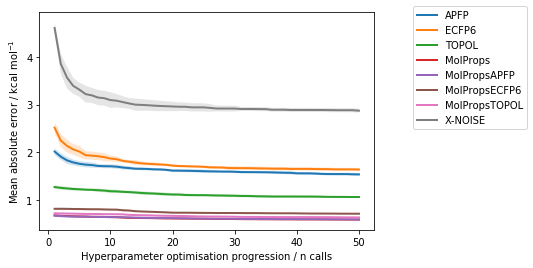

In [13]:
# make a list with all our MAE outputs:
MAE_output_dfs = []
replicate_tags = [ "repl"+str(value) for value in np.arange(1,11) ]
maes_per_featureset = []
for feature_set in feature_sets:
    maes_all_replicates = []
    for replicate in replicate_tags:
        mae_logger = output_dr + feature_set + '/null_mae_per_call'+replicate+'.csv'
        mae_df = pd.read_csv(mae_logger).head(n_calls*n_splits)  # Load previously defined training statistics logger.
        maes_all_replicates.append([replicate, feature_set, mae_df])
    maes_per_featureset.append(maes_all_replicates)
        

# Plot convergence plots.

mae_convergence(maes_per_featureset)  

All generated models and logs are saved in ./output/
Note that because of hyperparameter optimision per fold, each fold model will have a different
hyperparameter configuration. The specific configurations can be retrieved from the outputs above.


The convergence plot is saved ./figures/